In [1]:
import pandas as pd
from pathlib import Path
import json
import gzip
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
#%matplotlib widget

In [3]:
DATA_FOLDER = "data"
CHARGE_FOLDER = "charge"
STATIONS_FOLDER = "stations"
FIG_DIR = "fig"

In [4]:
Path(FIG_DIR).mkdir(exist_ok=True)

In [5]:
df_charge = pd.read_parquet(Path("data/charge/"), engine="pyarrow")
df_charge = df_charge.drop('DATE', axis=1) # only used for partitioning
df_charge.sort_values(by=["TIME", "STATION_ID"], inplace=True)
df_charge.head(5)

,STATION_ID,STATUS,TIME
0,+41*001*10*1,Unknown,2025-12-22 14:43:00
1,+41*001*1622*1,Available,2025-12-22 14:43:00
2,+41*001*9*1,Unknown,2025-12-22 14:43:00
3,+41*002*104*1,Available,2025-12-22 14:43:00
4,+41*002*105*1,Available,2025-12-22 14:43:00


In [6]:
# Load the newest file in the folder ()

stations_path = Path(DATA_FOLDER) / STATIONS_FOLDER 
static_path = Path(DATA_FOLDER) / STATIONS_FOLDER
files = glob.glob(str(static_path / "stations_*.json.gz"))
latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)

with gzip.open(latest_file, "rt", encoding="utf-8") as file:
	stations = json.load(file)["EVSEData"]

In [7]:
# Series of operator IDs to names
ser_operators = pd.Series({operator['OperatorID']: operator['OperatorName'] for operator in stations})
ser_operators.head(5)

CH*SWISSCHARGE    Swisscharge
CH*CCC                   Move
CH*ECU                 eCarUp
CH*FASTNED            Fastned
CH*REP            PLUG N ROLL
dtype: object

In [8]:
len(ser_operators)

37

In [9]:
# Statons static info
rows = []
for operator in stations:
    for station in operator['EVSEDataRecord']:
        row = station
        row['Operator'] = operator['OperatorID']
        rows.append(row)
df_stations = pd.DataFrame(rows)

df_stations.head(5) # 17512 stations

,AccessibilityLocation,Address,AuthenticationModes,CalibrationLawDataAvailability,ChargingFacilities,ChargingStationNames,DynamicInfoAvailable,HotlinePhoneNumber,HubOperatorID,IsHubjectCompatible,...,LocationImage,SuboperatorName,MaxCapacity,AdditionalInfo,ChargingPoolID,DynamicPowerLevel,HardwareManufacturer,Operator,ChargingPoolId,SubOperatorName
0,OnStreet,"{'HouseNum': '0', 'TimeZone': 'UTC+01:00', 'Ci...","[NFC RFID Classic, REMOTE]",Not Available,"[{'power': 20, 'powertype': 'DC'}, {'power': 2...","[{'lang': 'de', 'value': 'Suissetec Lostorf'}]",true,+41713881150,CH*SWISSCHARGE,True,...,None,None,NaN,None,None,None,None,CH*SWISSCHARGE,NaN,NaN
1,OnStreet,"{'HouseNum': '0', 'TimeZone': 'UTC+01:00', 'Ci...","[NFC RFID Classic, REMOTE]",Not Available,"[{'power': 22, 'powertype': 'AC_3_PHASE'}]","[{'lang': 'de', 'value': 'Suissetec Lostorf'}]",true,+41713881150,CH*SWISSCHARGE,True,...,None,None,NaN,None,None,None,None,CH*SWISSCHARGE,NaN,NaN
2,OnStreet,"{'HouseNum': '0', 'TimeZone': 'UTC+01:00', 'Ci...","[NFC RFID Classic, REMOTE]",Not Available,[],"[{'lang': 'de', 'value': 'Suissetec Lostorf'}]",true,+41713881150,CH*SWISSCHARGE,True,...,None,None,NaN,None,None,None,None,CH*SWISSCHARGE,NaN,NaN
3,OnStreet,"{'HouseNum': '0', 'TimeZone': 'UTC+01:00', 'Ci...","[NFC RFID Classic, REMOTE]",Not Available,[],"[{'lang': 'de', 'value': 'Suissetec Lostorf'}]",true,+41713881150,CH*SWISSCHARGE,True,...,None,None,NaN,None,None,None,None,CH*SWISSCHARGE,NaN,NaN
4,OnStreet,"{'HouseNum': '0', 'TimeZone': 'UTC+01:00', 'Ci...","[NFC RFID Classic, REMOTE]",Not Available,[],"[{'lang': 'de', 'value': 'Suissetec Lostorf'}]",true,+41713881150,CH*SWISSCHARGE,True,...,None,None,NaN,None,None,None,None,CH*SWISSCHARGE,NaN,NaN


In [10]:
df_stations.columns

Index(['AccessibilityLocation', 'Address', 'AuthenticationModes',
       'CalibrationLawDataAvailability', 'ChargingFacilities',
       'ChargingStationNames', 'DynamicInfoAvailable', 'HotlinePhoneNumber',
       'HubOperatorID', 'IsHubjectCompatible', 'IsOpen24Hours',
       'PaymentOptions', 'Plugs', 'RenewableEnergy', 'ValueAddedServices',
       'deltaType', 'Accessibility', 'ChargingStationId', 'GeoCoordinates',
       'lastUpdate', 'EvseID', 'ClearinghouseID', 'OpeningTimes',
       'GeoChargingPointEntrance', 'ChargingStationLocationReference',
       'EnergySource', 'EnvironmentalImpact', 'LocationImage',
       'SuboperatorName', 'MaxCapacity', 'AdditionalInfo', 'ChargingPoolID',
       'DynamicPowerLevel', 'HardwareManufacturer', 'Operator',
       'ChargingPoolId', 'SubOperatorName'],
      dtype='object')

In [11]:
len(df_stations)

17490

In [12]:
is_occupied = df_charge["STATUS"].eq("Occupied").astype(int)
df_charge['delta'] = (
    is_occupied
    .groupby(df_charge["STATION_ID"])
    .diff()
    .fillna(is_occupied)
)

occupied_count = (
    df_charge.groupby("TIME")['delta']
      .sum()
      .cumsum()
)

df_charge.tail(5)

,STATION_ID,STATUS,TIME,delta
575190,CH*ECUEW9M9PAPHXZ64BY3RTU37CEN9EQ,Available,2026-01-01 16:19:59,-1.0
575191,CH*ECUEWGA7P2GB32EA7B5X97PKKTGWLQ,Available,2026-01-01 16:19:59,-1.0
575192,CH*ECUEXWJ64MUGRZ65L6DAZQULBVPAAX,Occupied,2026-01-01 16:19:59,1.0
575193,CH*POW*E43522,Available,2026-01-01 16:19:59,0.0
575194,CH*POW*E43523,Available,2026-01-01 16:19:59,0.0


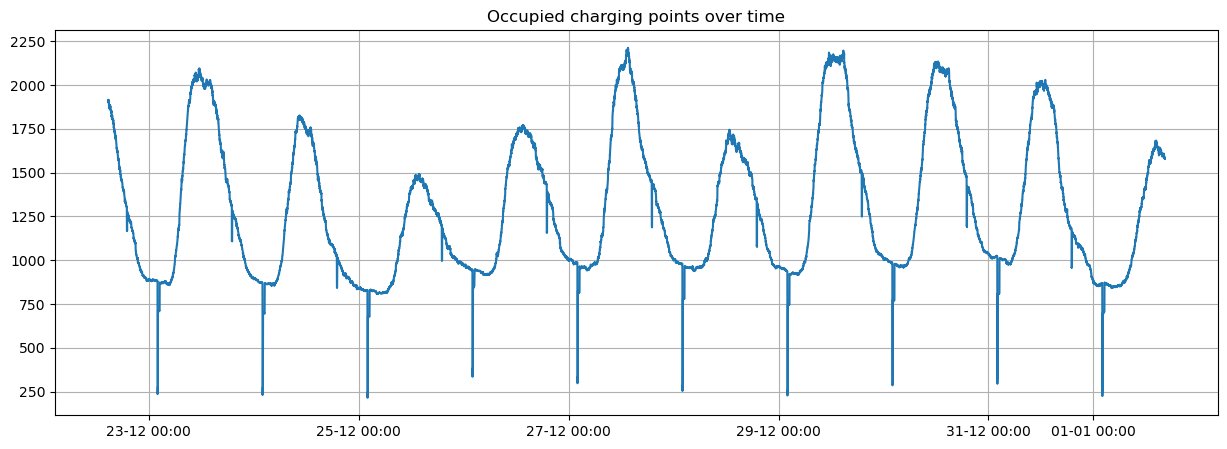

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(occupied_count, label='Occupied')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.grid()
plt.title("Occupied charging points over time")
plt.savefig(Path(FIG_DIR) / "occupied_total.png")
#plt.legend();

/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_3781/3786801998.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5))


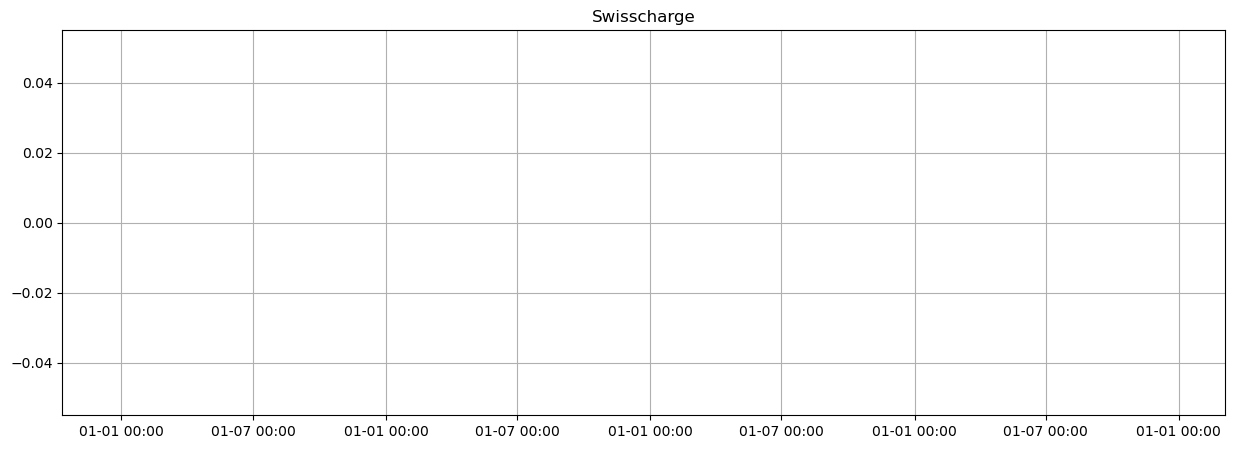

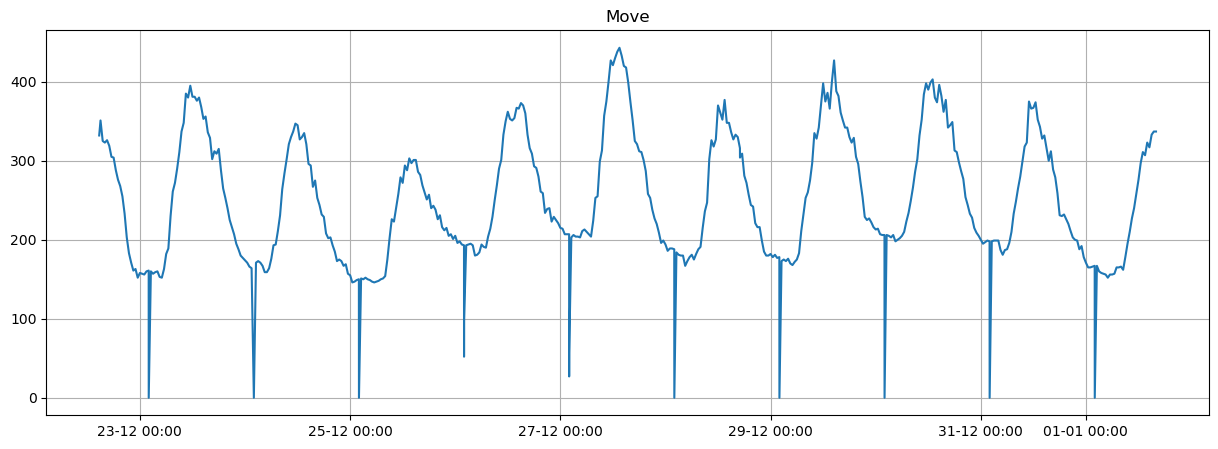

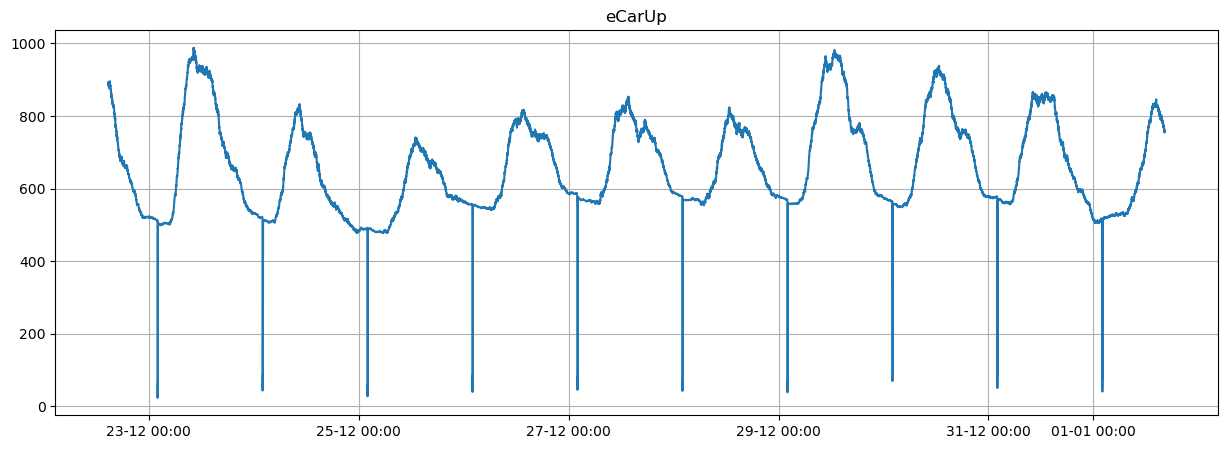

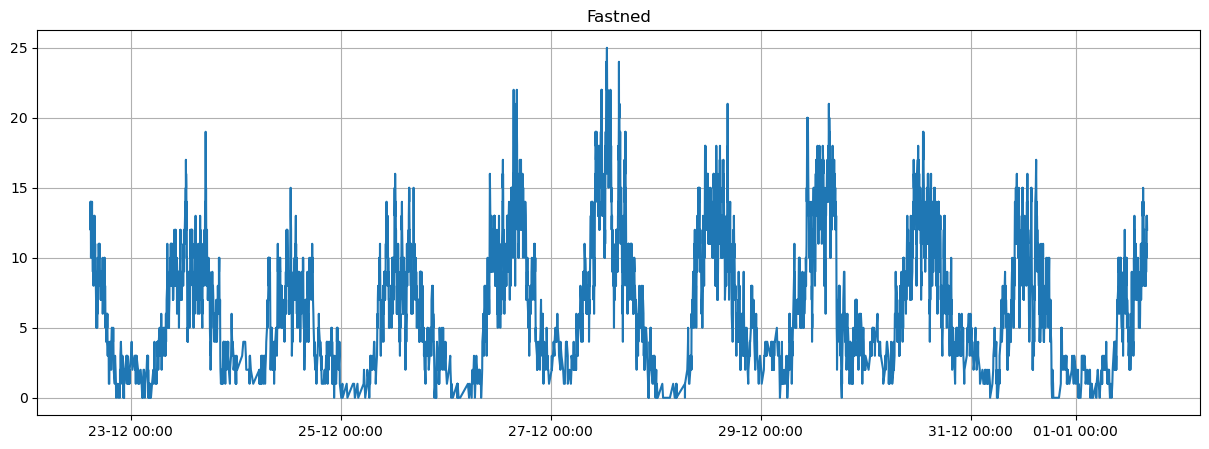

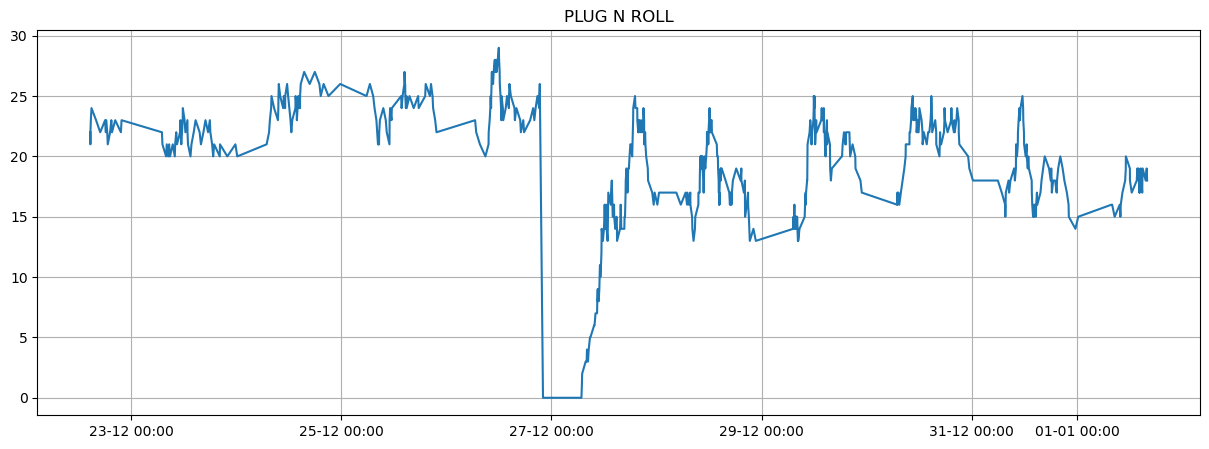

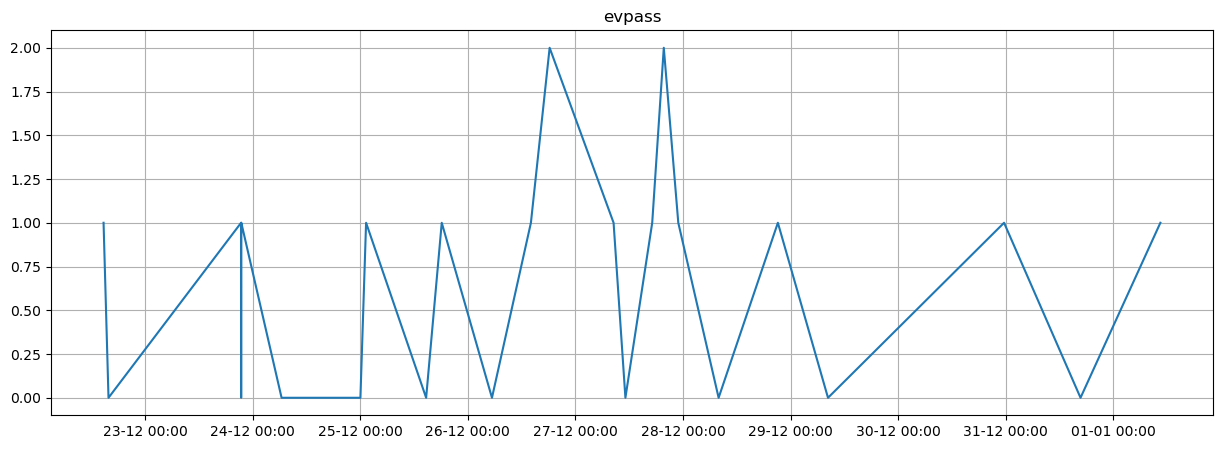

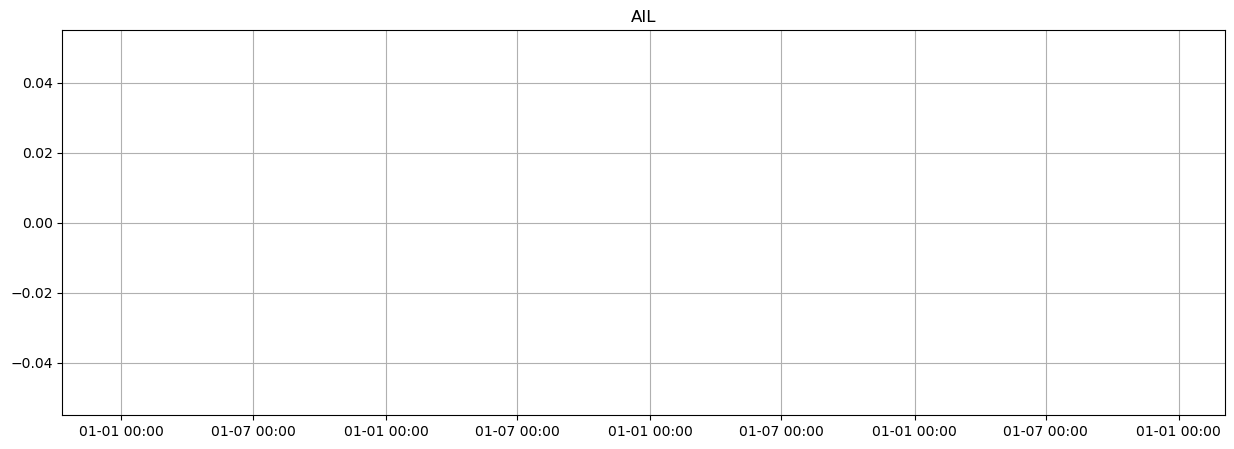

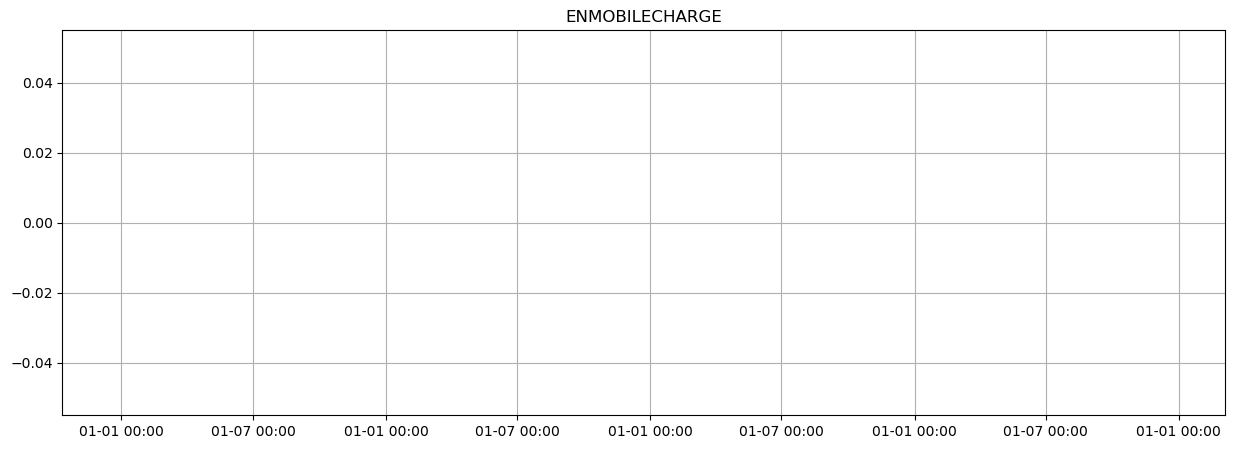

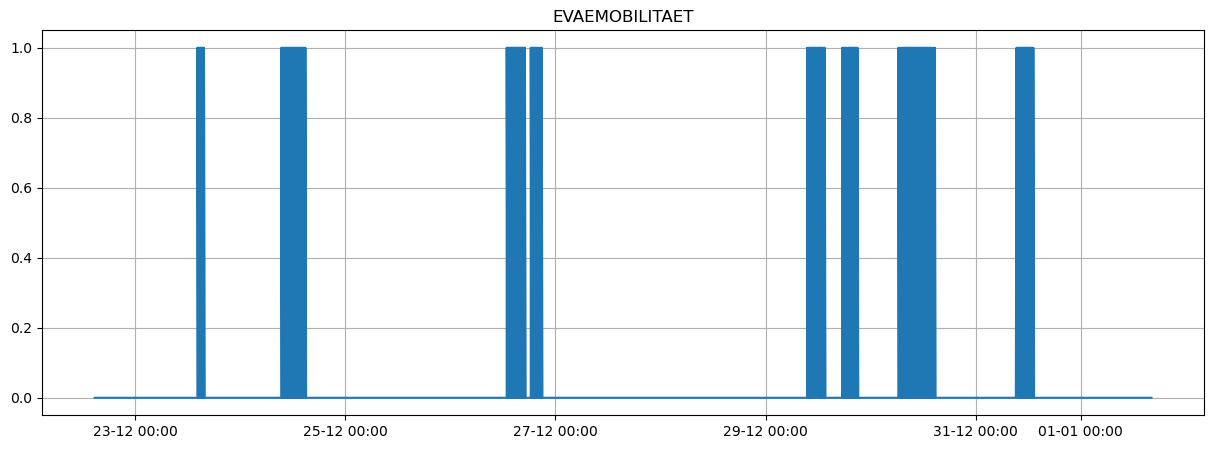

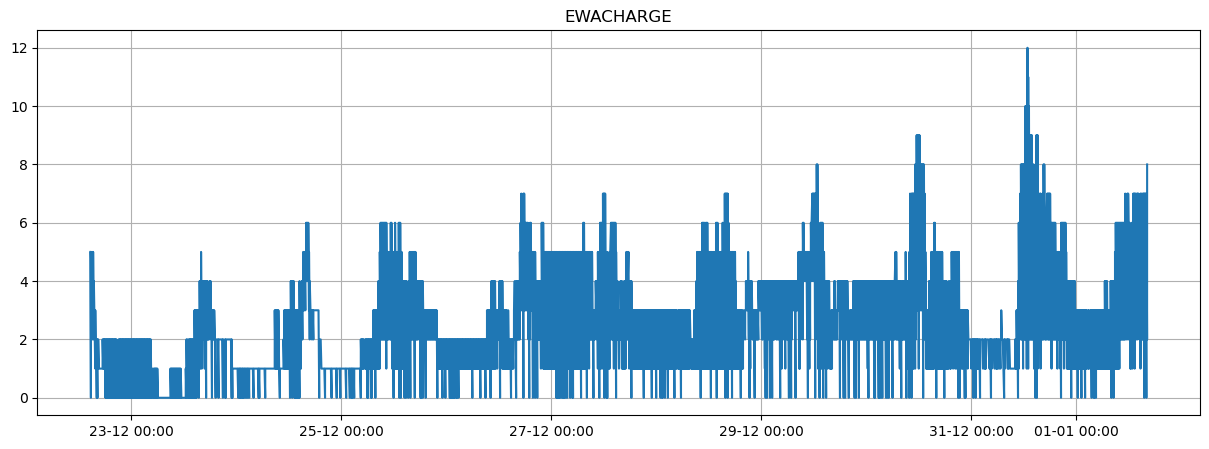

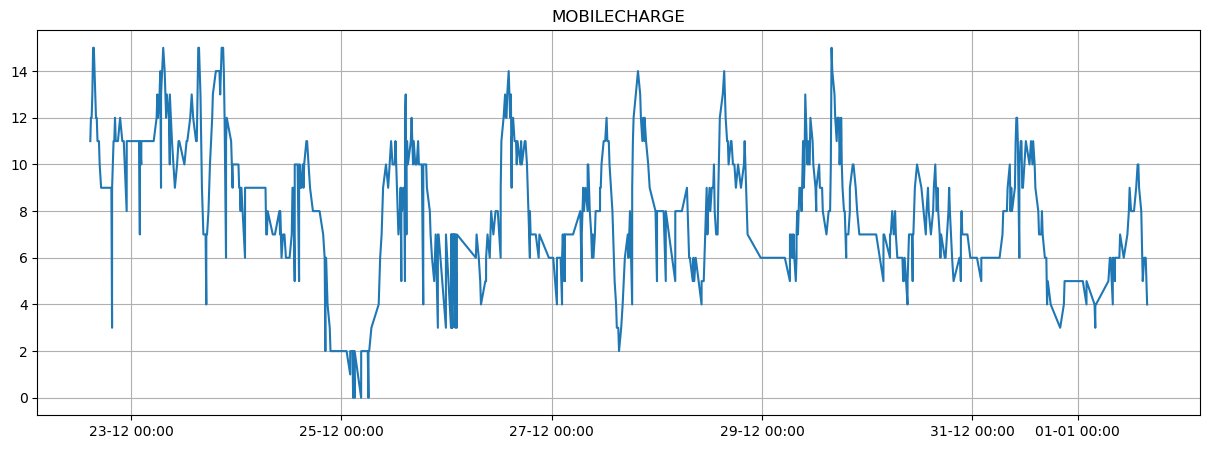

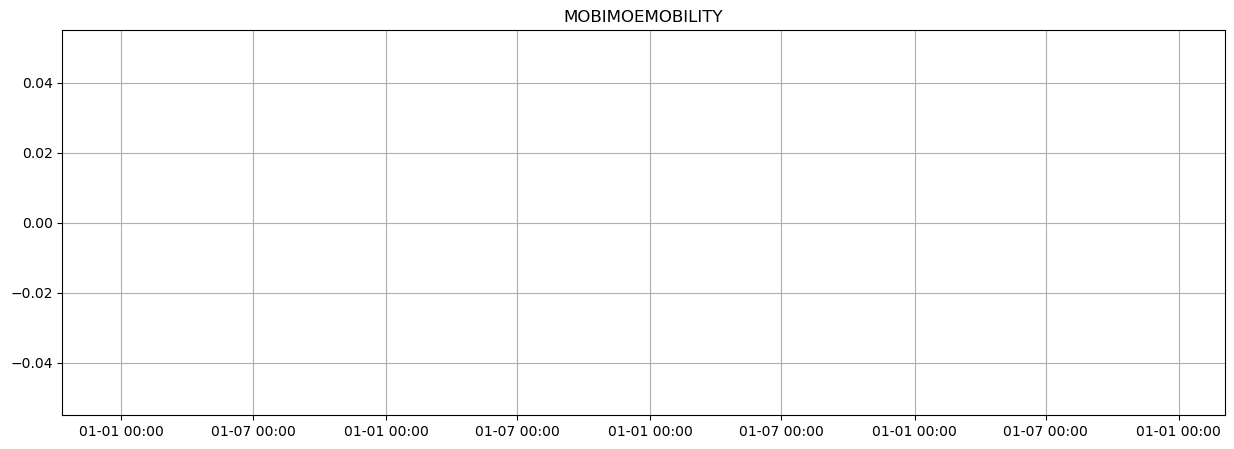

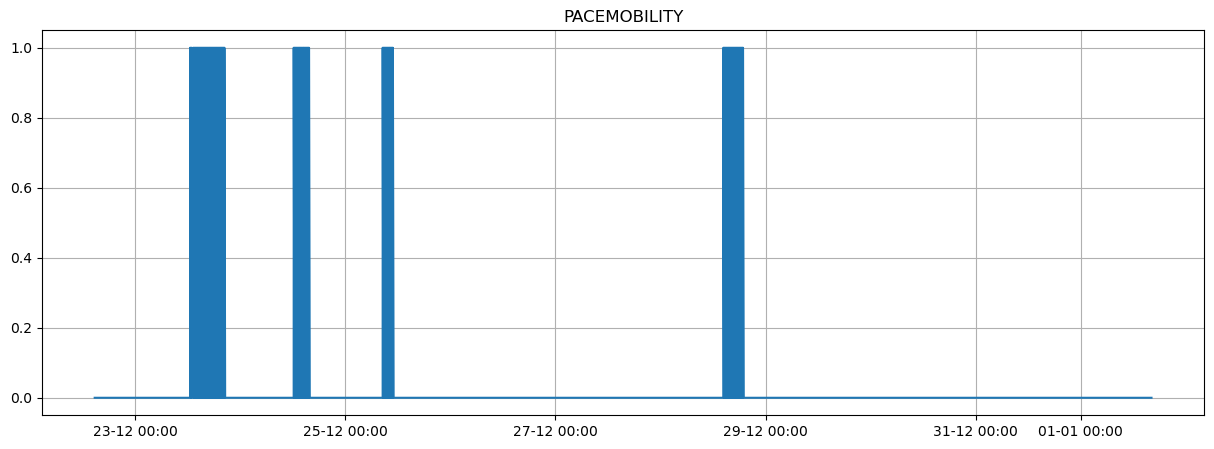

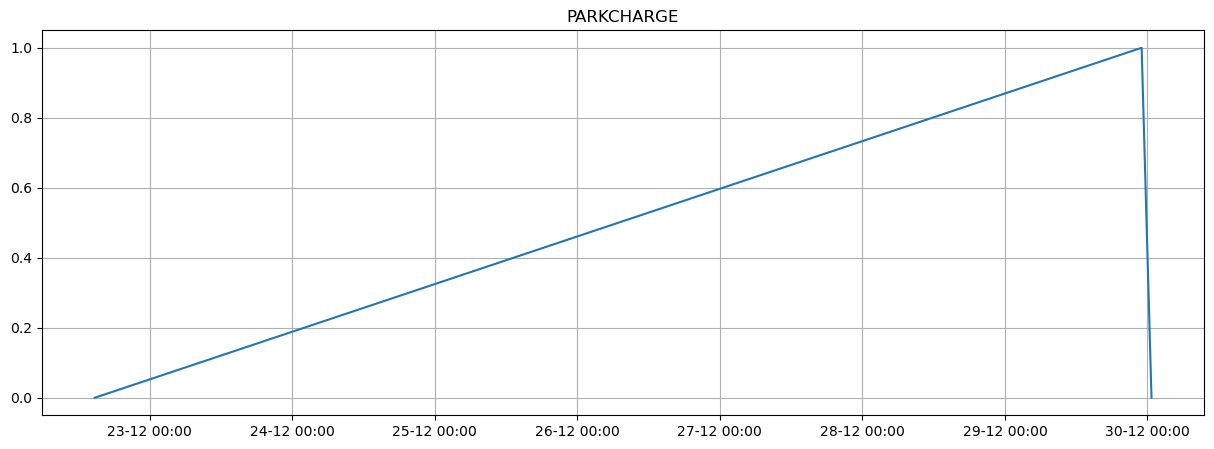

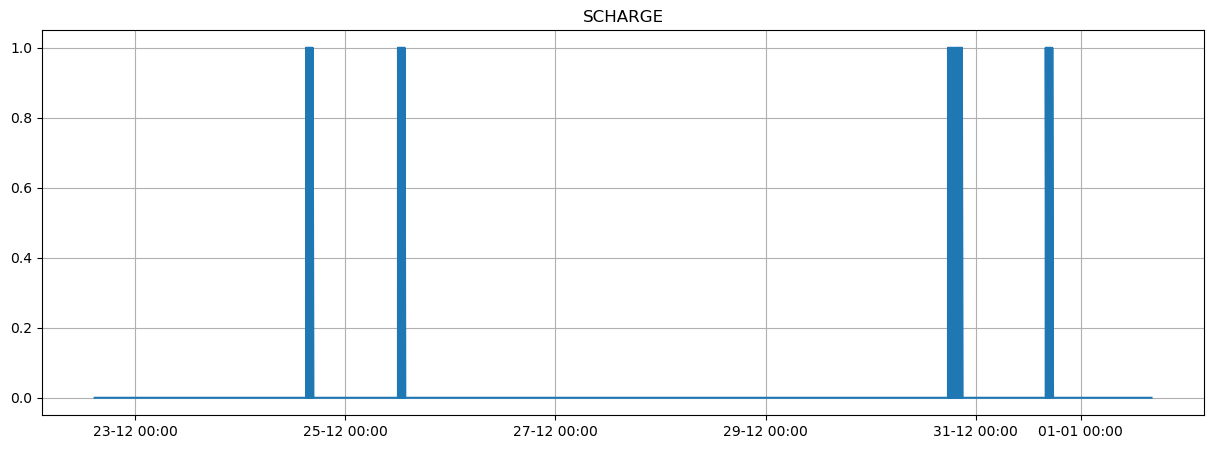

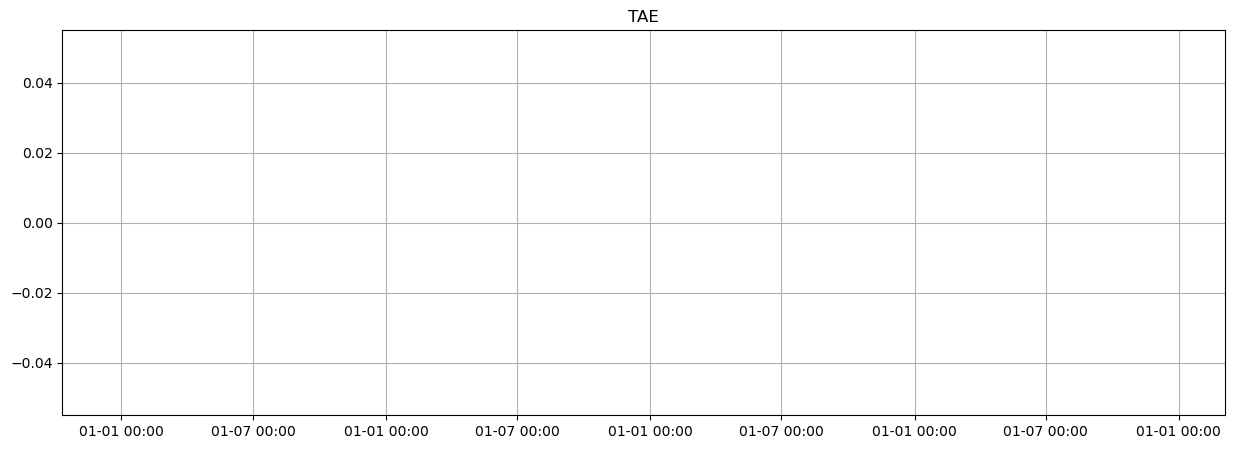

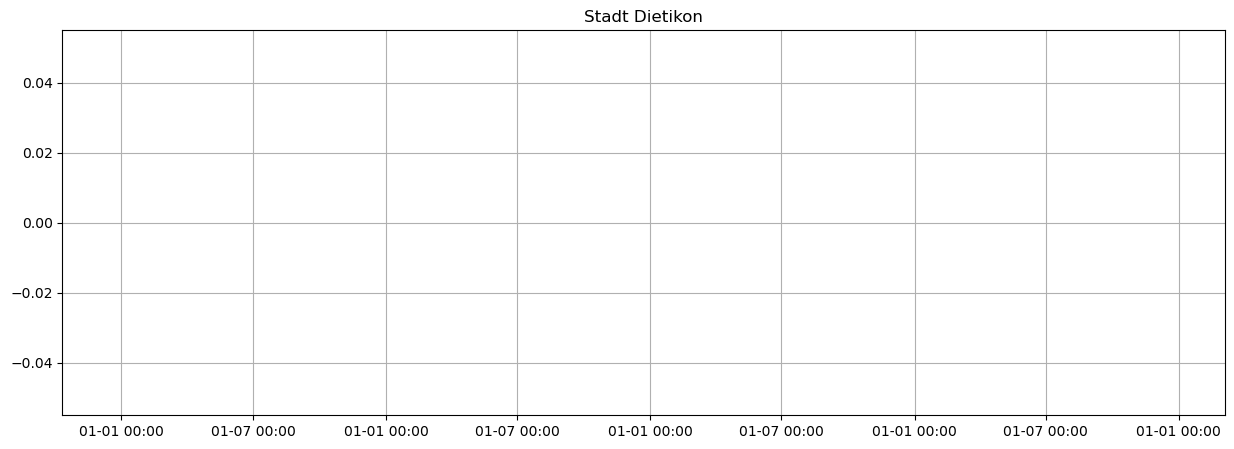

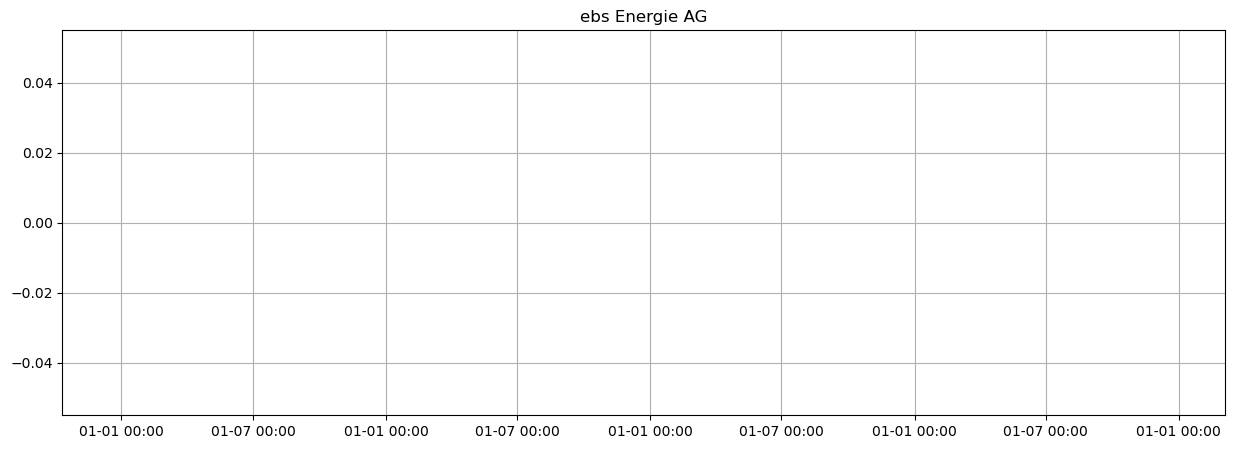

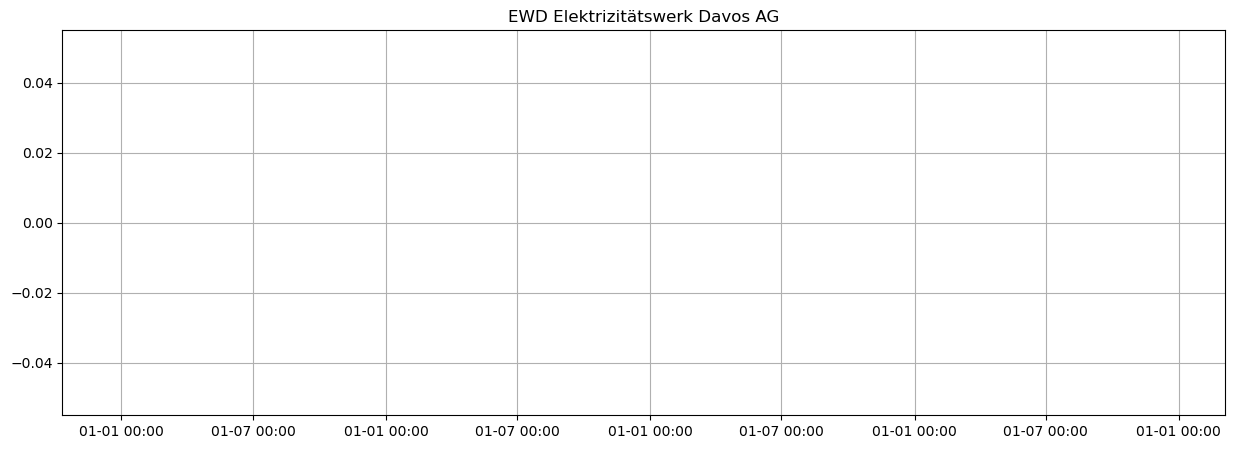

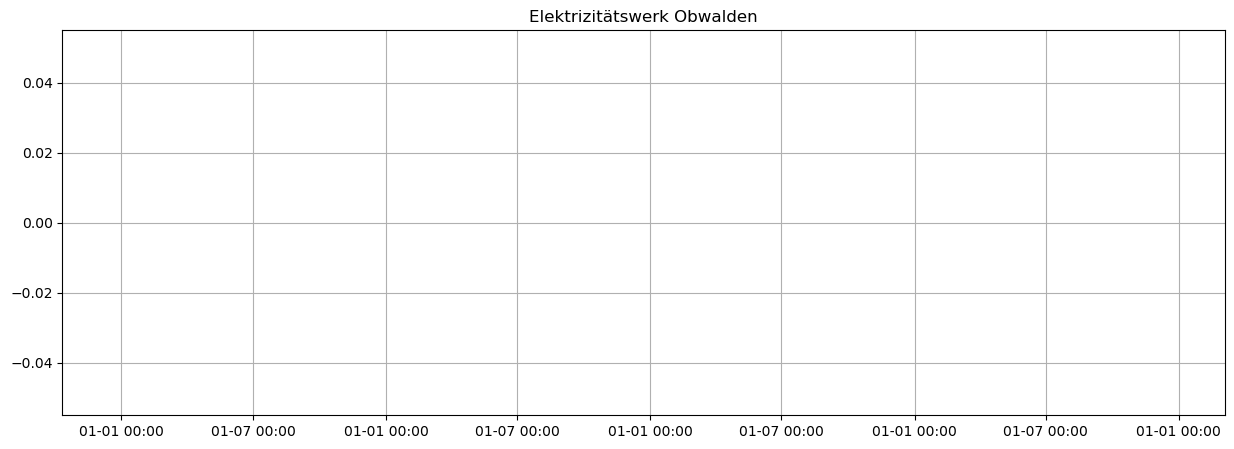

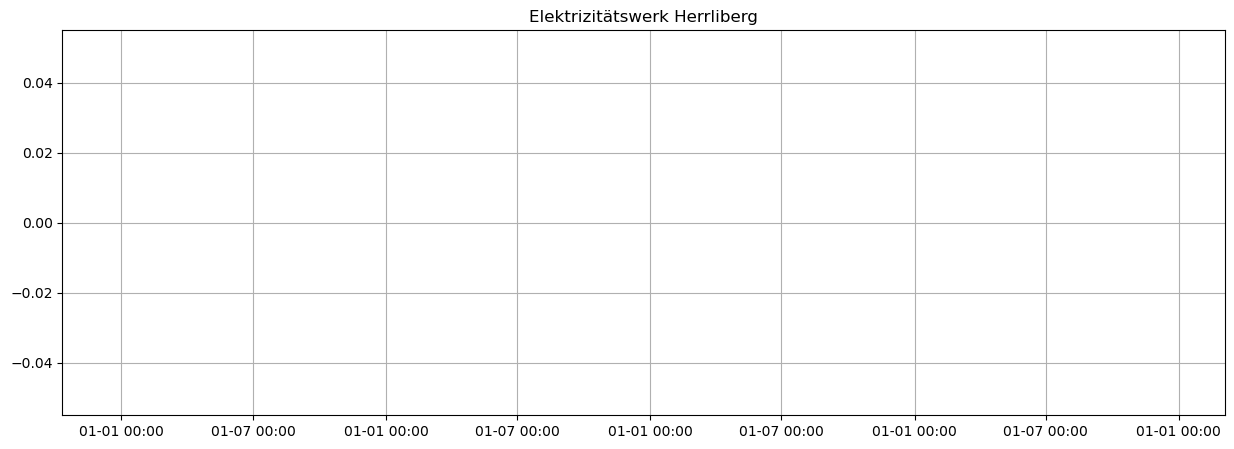

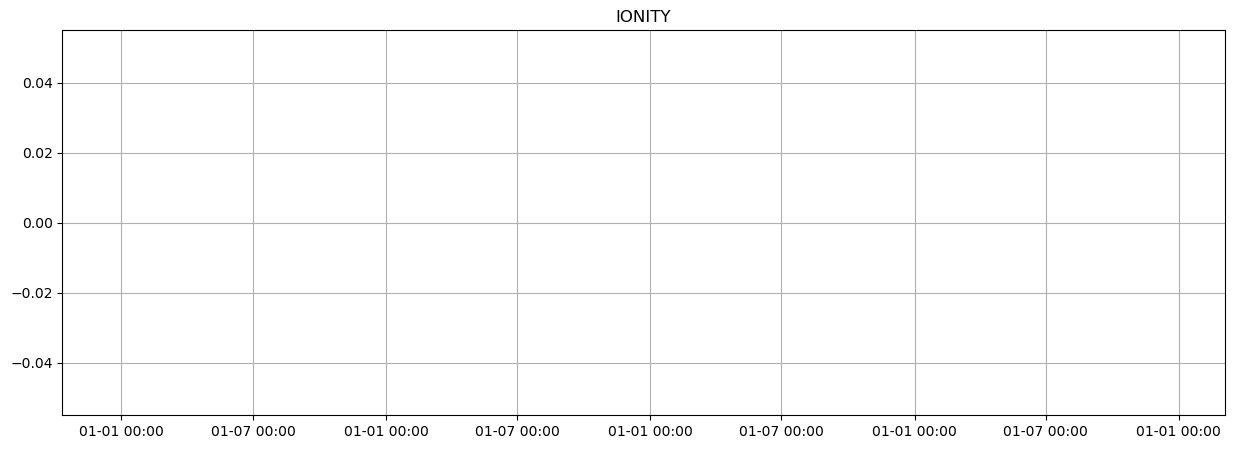

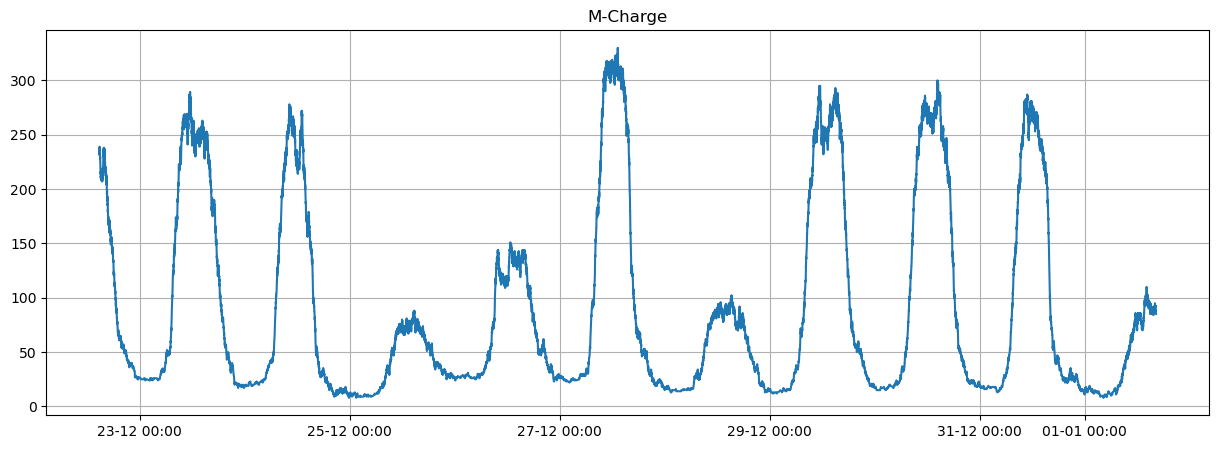

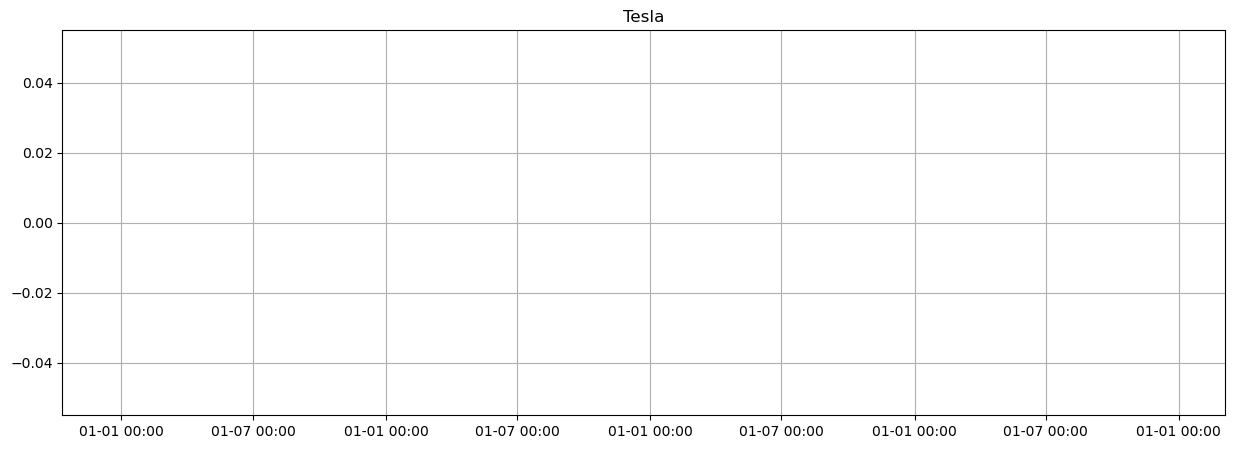

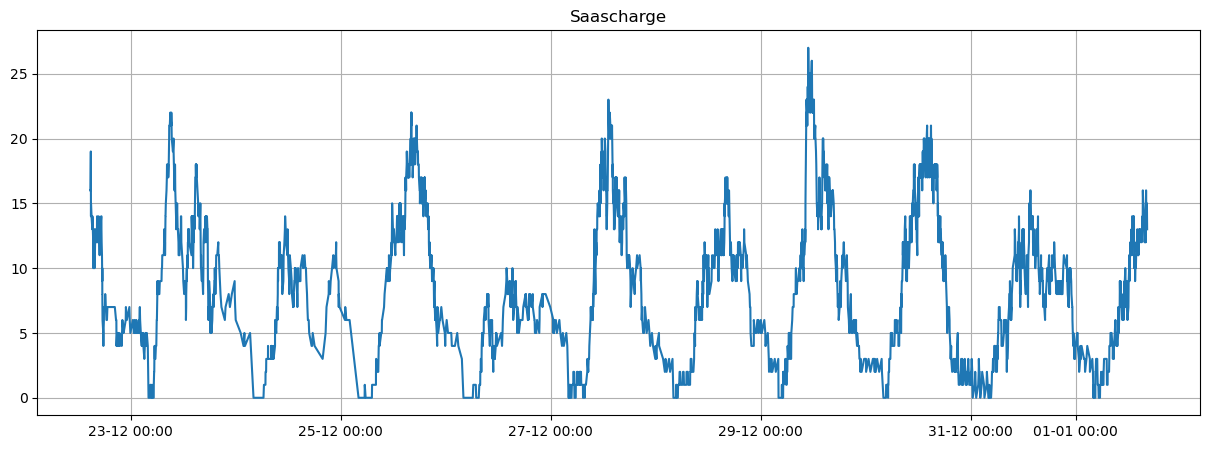

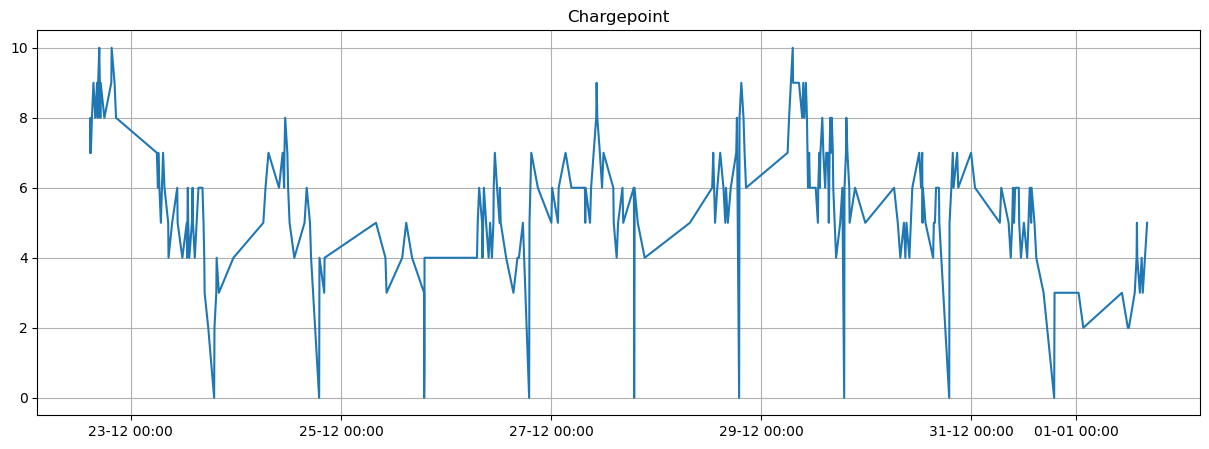

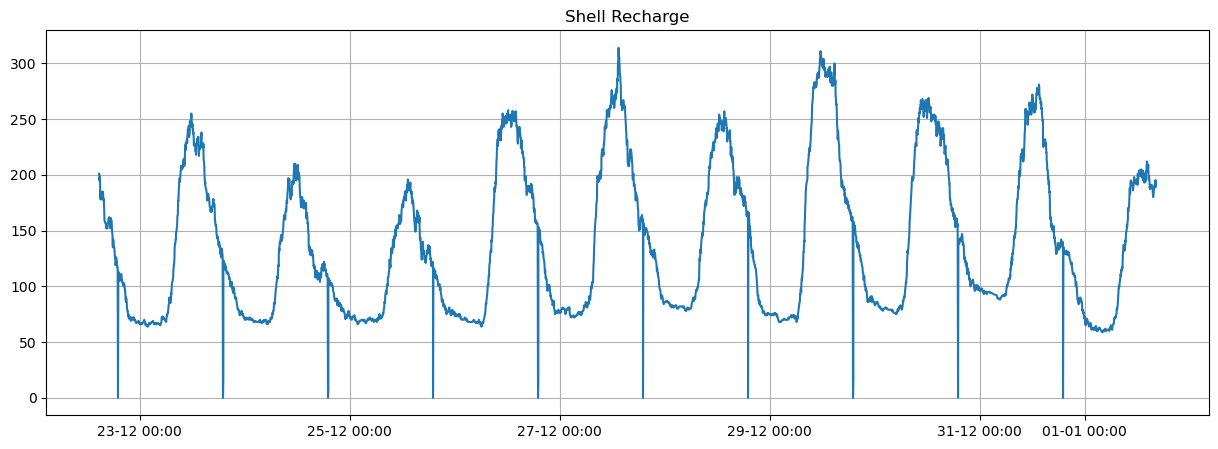

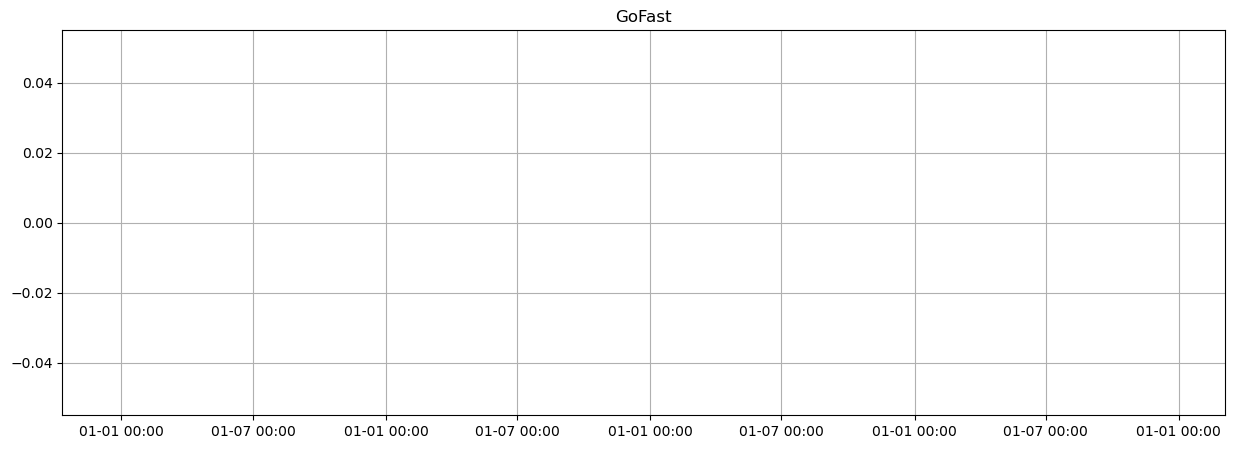

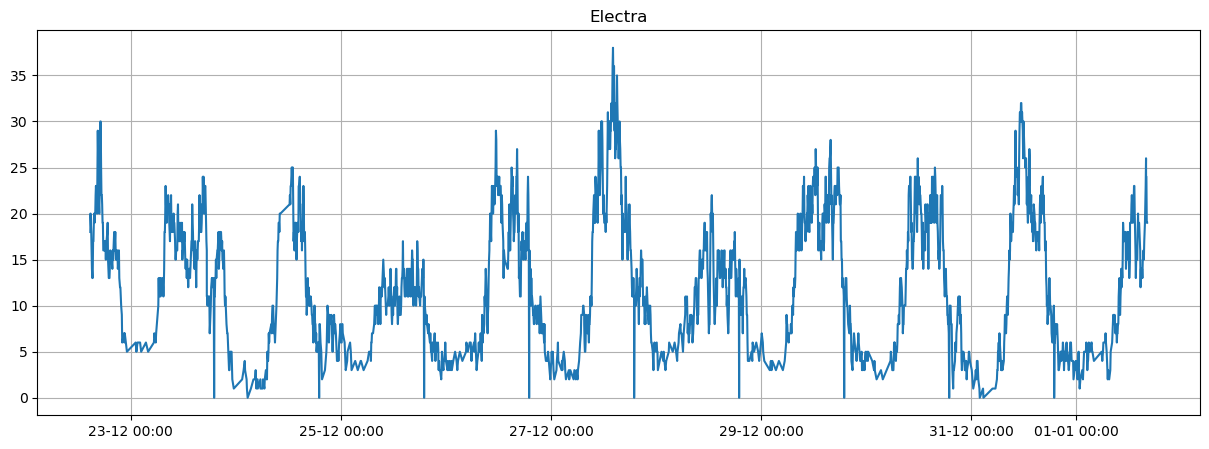

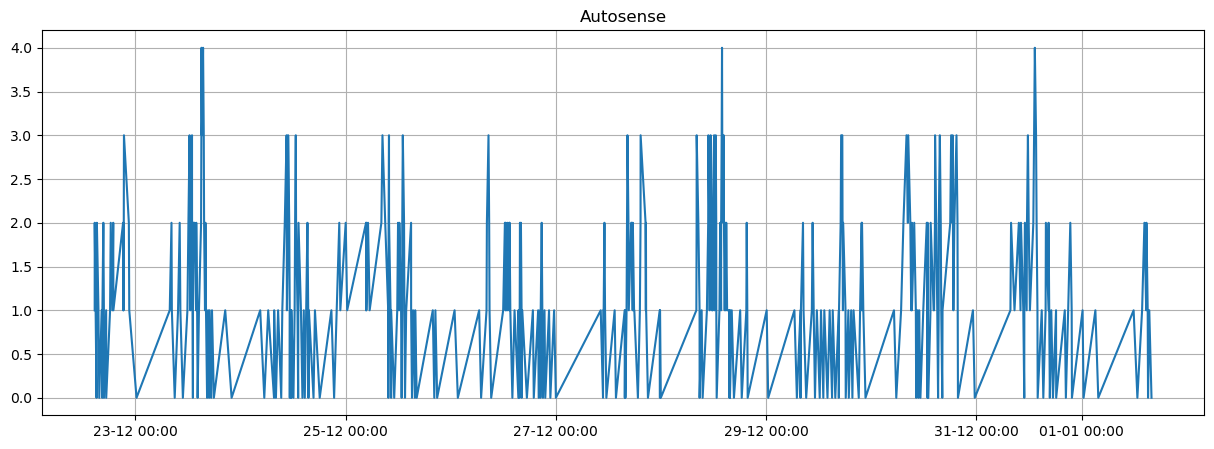

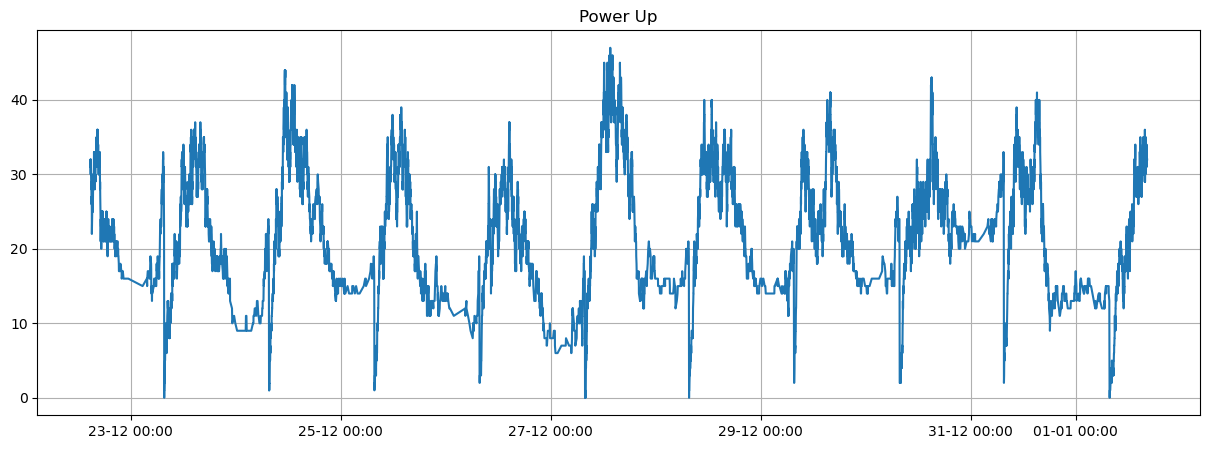

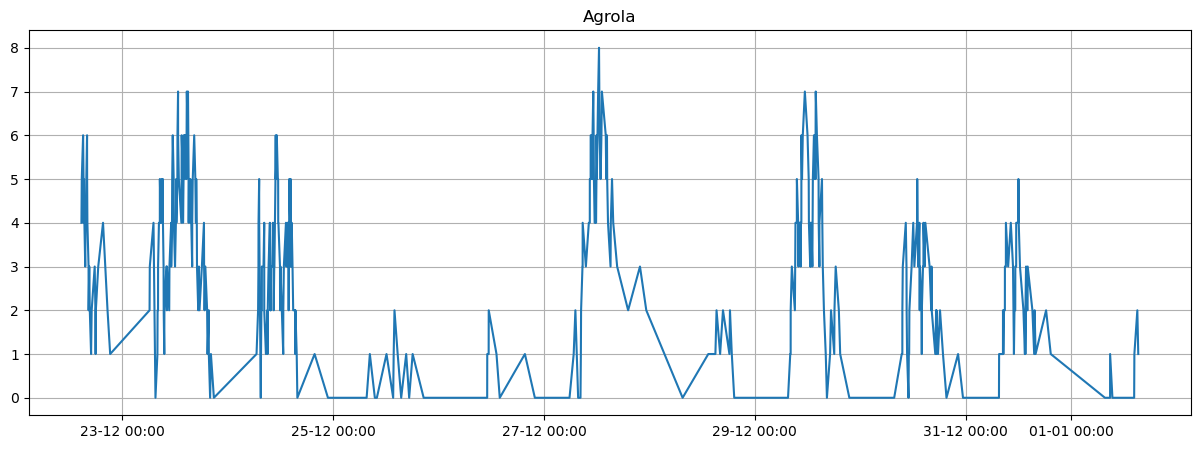

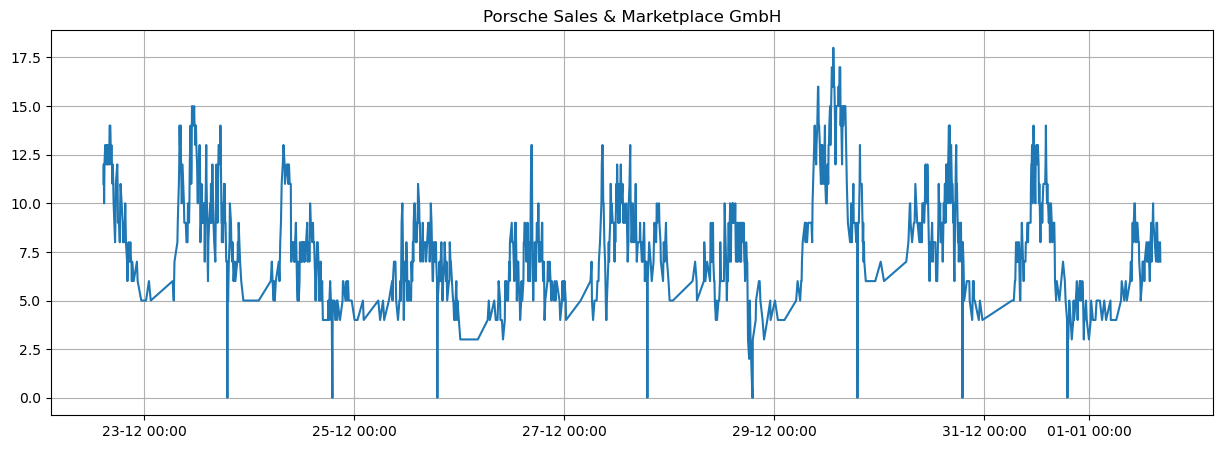

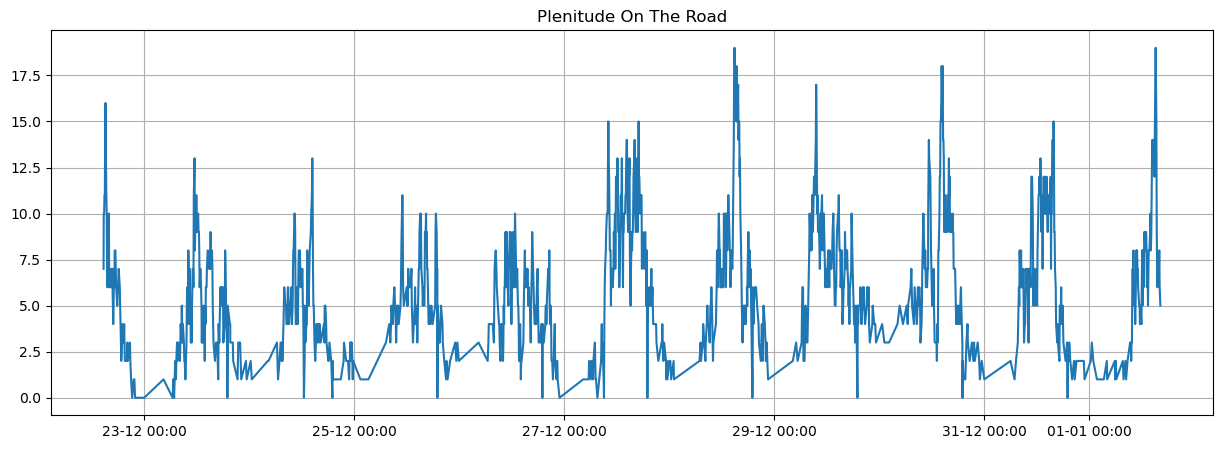

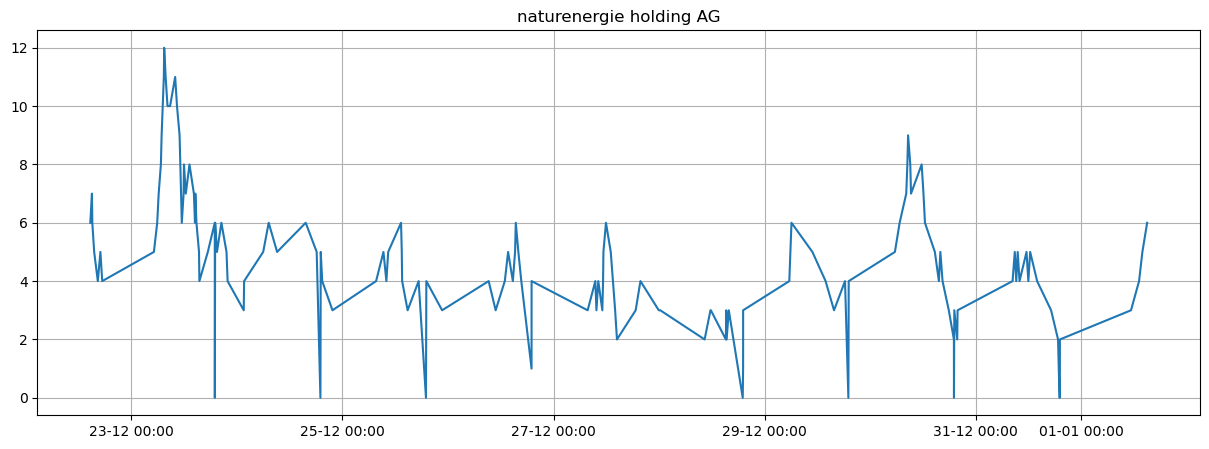

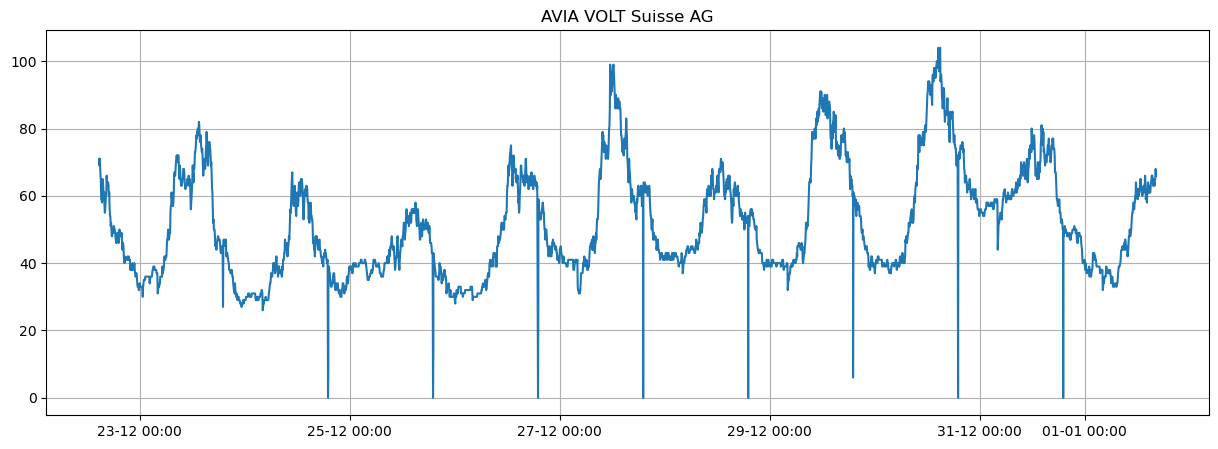

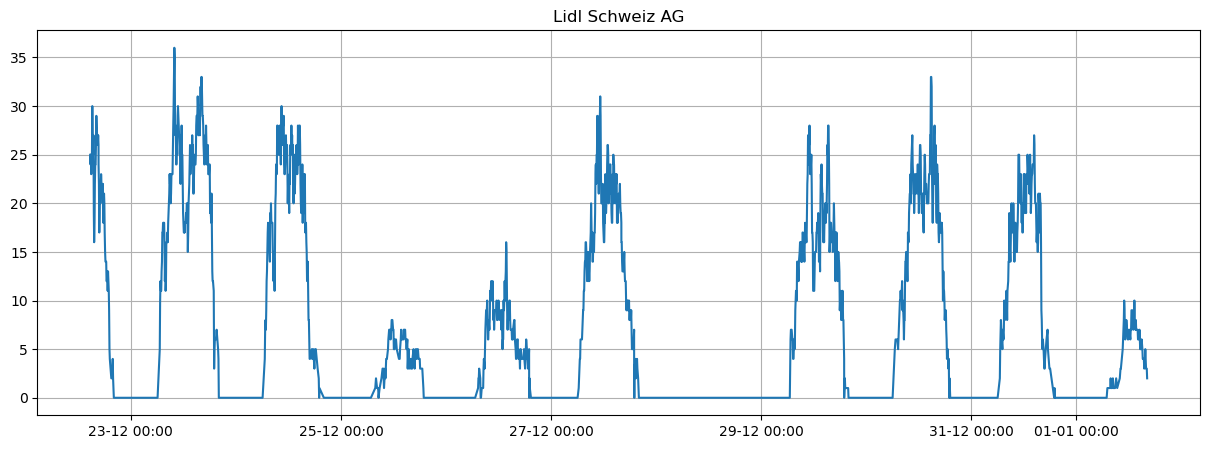

In [14]:
for operator_id, operator_name in ser_operators.items():
    points = df_stations.query('Operator == @operator_id')['EvseID']

    occupied_count = (
        df_charge[df_charge['STATION_ID'].isin(points)]
        .groupby("TIME")['delta']
        .sum()
        .cumsum()
    )
    plt.figure(figsize=(15, 5))
    plt.plot(occupied_count)
    plt.title(operator_name)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    plt.grid()
    plt.savefig(Path(FIG_DIR) / f"occupied_total_{operator_id}.png")

In [15]:
# Swisscharge status always unknown?
points_sc = df_stations.query('Operator == "CH*SWISSCHARGE"')['EvseID']
df_charge_sc = df_charge[df_charge['STATION_ID'].isin(points_sc)]
df_charge_sc['STATUS'].value_counts()

STATUS
Unknown    3985
Name: count, dtype: int64